In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [44]:
# data set downloaded from https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
PATH = "../../../data/dogImages/"
sz=224

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [7]:
#os.listdir(f'{PATH}valid')

In [8]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.04, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      1.333163   0.576422   0.819162  
    1      0.679517   0.491525   0.839521                    
    2      0.508407   0.457949   0.85988                    



[array([0.45795]), 0.859880239520958]

In [9]:
#data.classes

In [10]:
log_preds = learn.predict()
log_preds.shape

(835, 133)

In [16]:
preds = np.argmax(log_preds, axis=1) 
probs = np.exp(log_preds[:,1])  

In [17]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

Correctly classified


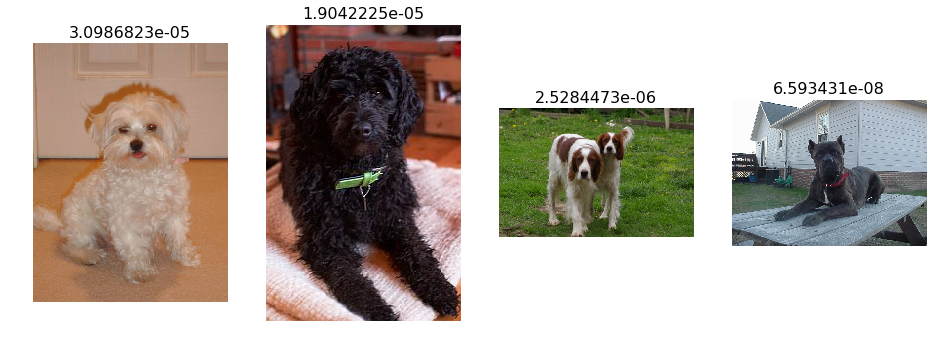

In [18]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [19]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct 81


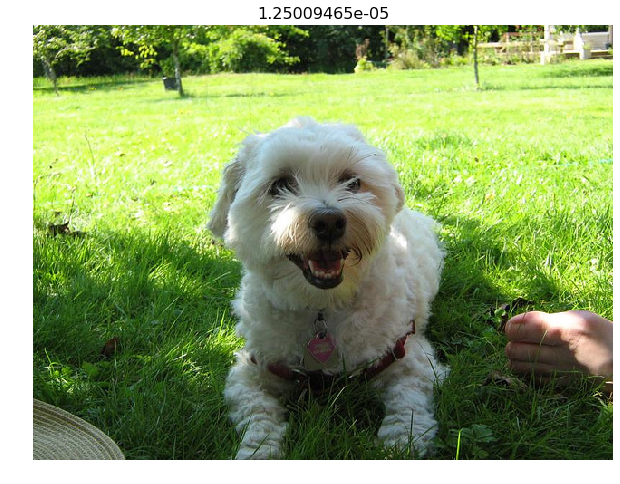

In [31]:
plot_val_with_title(most_by_correct(81, True), "Most correct 81")

Most incorrect 81


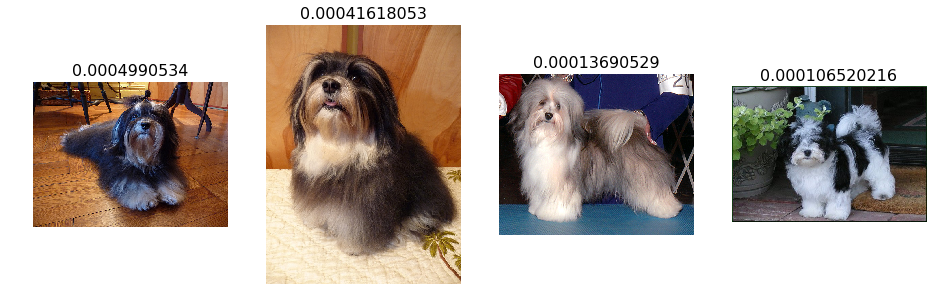

In [32]:
plot_val_with_title(most_by_correct(81, False), "Most incorrect 81")

In [33]:
# determining learning rate

learn = ConvLearner.pretrained(arch, data, precompute=True)

In [34]:
lrf=learn.lr_find()

 84%|████████▍ | 88/105 [00:01<00:00, 40.48it/s, loss=3.7] 


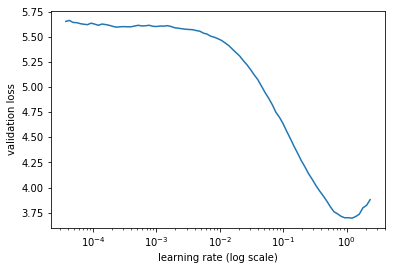

In [35]:
learn.sched.plot()

In [36]:
# Improvinf the model through data augmentation
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [37]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [38]:
ims = np.stack([get_augs() for i in range(6)])

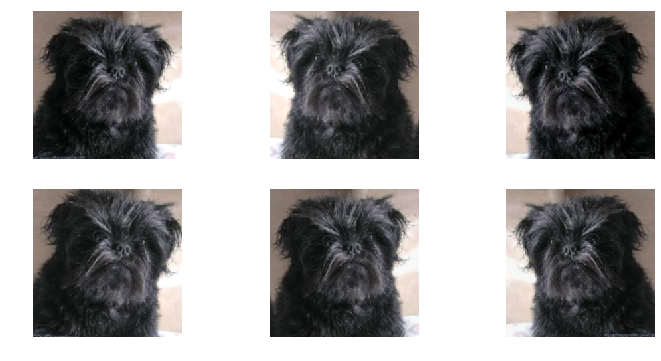

In [39]:
plots(ims, rows=2)

In [40]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [41]:
learn.fit(0.04, 1)

epoch      trn_loss   val_loss   accuracy                  
    0      1.30809    0.549092   0.833533  



[array([0.54909]), 0.8335329341317366]

In [42]:
learn.precompute=False

In [43]:
learn.fit(0.04, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.636594   0.440795   0.869461  
    1      0.566587   0.407212   0.867066                    
    2      0.523651   0.399649   0.873054                    



[array([0.39965]), 0.8730538922155688]

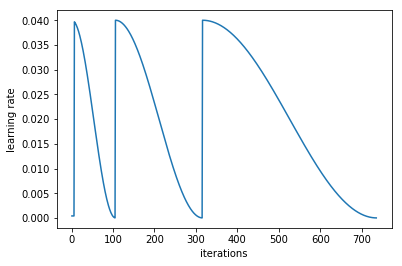

In [59]:
learn.sched.plot_lr()

In [46]:
learn.save('dog-breed-last-layer')

In [47]:
learn.load('dog-breed-last-layer')

In [50]:
# fine tuning by giving different learning rates for each layer
learn.unfreeze() # to tune layer by layer
lr=np.array([0.005,0.01,0.04])

In [51]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.894727   0.482927   0.843114  
    1      0.853788   0.605826   0.821557                    
    2      0.485695   0.39704    0.874251                    
    3      0.632168   0.856474   0.747305                    
    4      0.457767   0.568153   0.822754                    
    5      0.251885   0.392233   0.877844                    
    6      0.167467   0.375374   0.877844                    



[array([0.37537]), 0.8778443113772455]

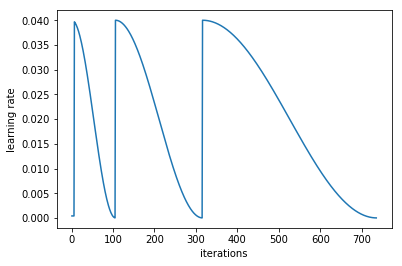

In [53]:
learn.sched.plot_lr()

In [54]:
learn.save('dog-breed-all')

In [55]:
learn.load('dog-breed-all')

In [56]:
# predictions on randomble augmented data
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [57]:
accuracy_np(probs, y)

0.8874251497005988